# Gaussian Mixture Models

- Based on: https://ai.plainenglish.io/gaussian-mixture-models-in-clustering-cc5dcf0ab201

## Needed libraries

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import numpy as np

## First: Let's try K-Means

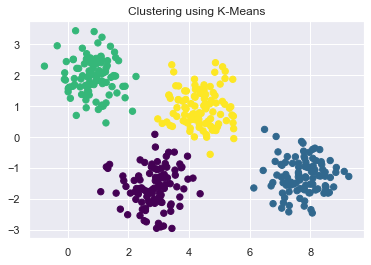

In [36]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.title("Clustering using K-Means")
plt.show()

**Some drawbacks:**
- there appears to be a very slight overlap between the two central clusters, such that we might not have complete confidence in the cluster assignment of points between them. 
- k-means model has no natural measure of probability or uncertainty of cluster assignments  
- So we need to think about generalizing the model:
 - one approach: it places a circle at the center of each cluster with a radius defined by its most distant point. 
 - This radius works as a hard cutoff for cluster tasks within the training set: any point outside this circle is not considered a cluster member. We visualize this cluster model with the following function:

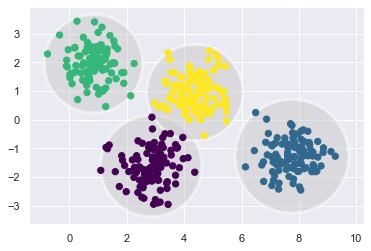

In [33]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

- **clusters are circular**: k-means has no built-in way of accounting for rectangular or elliptical clusters. 
- if the data is transformed, the cluster assignments end up becoming muddled

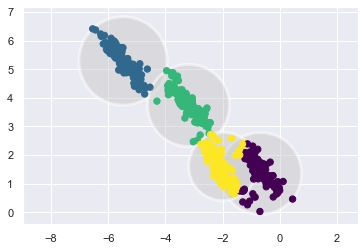

In [21]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

- the cluster assignments generate overlapping, especially the bottom-right plot. 
- what about using PCA? $\rightarrow$ there is no guarantee that such a global operation will circularize the individual data in practice.

- These disadvantages of k-means — its absence of flexibility in cluster shape and lack of probabilistic cluster assignment — mean that it may not perform for many datasets as well as you expect for many datasets.
- measuring  uncertainty in cluster assignment?
- cluster boundaries to be ellipses rather than circles to account for non-circular clusters?

## Using GMM

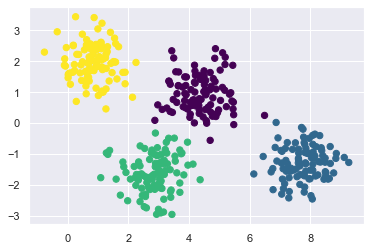

In [23]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

- GMM contains a probabilistic model $\rightarrow$ it is possible to find probabilistic cluster assignments (the predict_proba method)
- This yields a matrix of size [n_samples, n_clusters], which measures the probability that any point belongs to the given cluster:

In [34]:
probs = gmm.predict_proba(X)
print(probs)
print(probs[:5].round(3))

[[1.30234852e-046 1.00000000e+000 4.36835917e-256 2.36157367e-105]
 [3.54775978e-017 9.99999984e-001 2.43657944e-061 1.56546954e-008]
 [3.40990754e-020 1.00000000e+000 2.18214429e-072 3.86244698e-014]
 ...
 [9.98716281e-018 1.00000000e+000 3.45959235e-070 2.37577481e-027]
 [3.53006699e-030 1.00000000e+000 5.82219906e-120 3.95136550e-049]
 [8.04514705e-015 1.00000000e+000 3.73408186e-064 2.47074473e-026]]
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


## Visualizing uncertainty

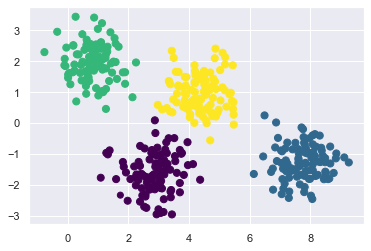

In [45]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [46]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

array([[[ 0.40398685, -0.00235346],
        [-0.00235346,  0.36933794]],

       [[ 0.29768676, -0.02444193],
        [-0.02444193,  0.34173529]],

       [[ 0.36530305,  0.01293533],
        [ 0.01293533,  0.28921965]],

       [[ 0.38465995,  0.02716798],
        [ 0.02716798,  0.37394003]]])

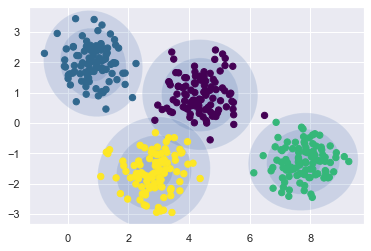

In [30]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)
gmm.covariances_

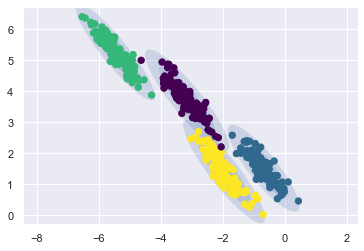

In [32]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)